# Deep Learning Project: corrosion detection on steel pipes

_Teacher: Emmanuelle Claeys_

_Student: Thomas Labreur (student ID: 21512408)_

_M2 SID University Toulouse III Paul Sabatier_

This notebook contains the main part of the deep learning project I performed in 2024. The aim is studying images representing pipes thickness and to identify areas with corrosion. For that, a convolutionnal neural network (CNN) will be trained on those images which have been cut into patches of 36x36 pixels.


In [2]:
# Generic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import gc
import random

# Deep learning modules
from keras import Model
from keras.layers import Conv2D, Dense, Input, Flatten
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# My own modules 
from iou import IoU
from preprocessing import preprocess, data_augmentation

## Retreive data

Here one can find out how our data look like and below the groundtruth, in other words, the corrosion areas we want to detect. As one can see, some data have outlier pixels with high negative values, and other have missing values.

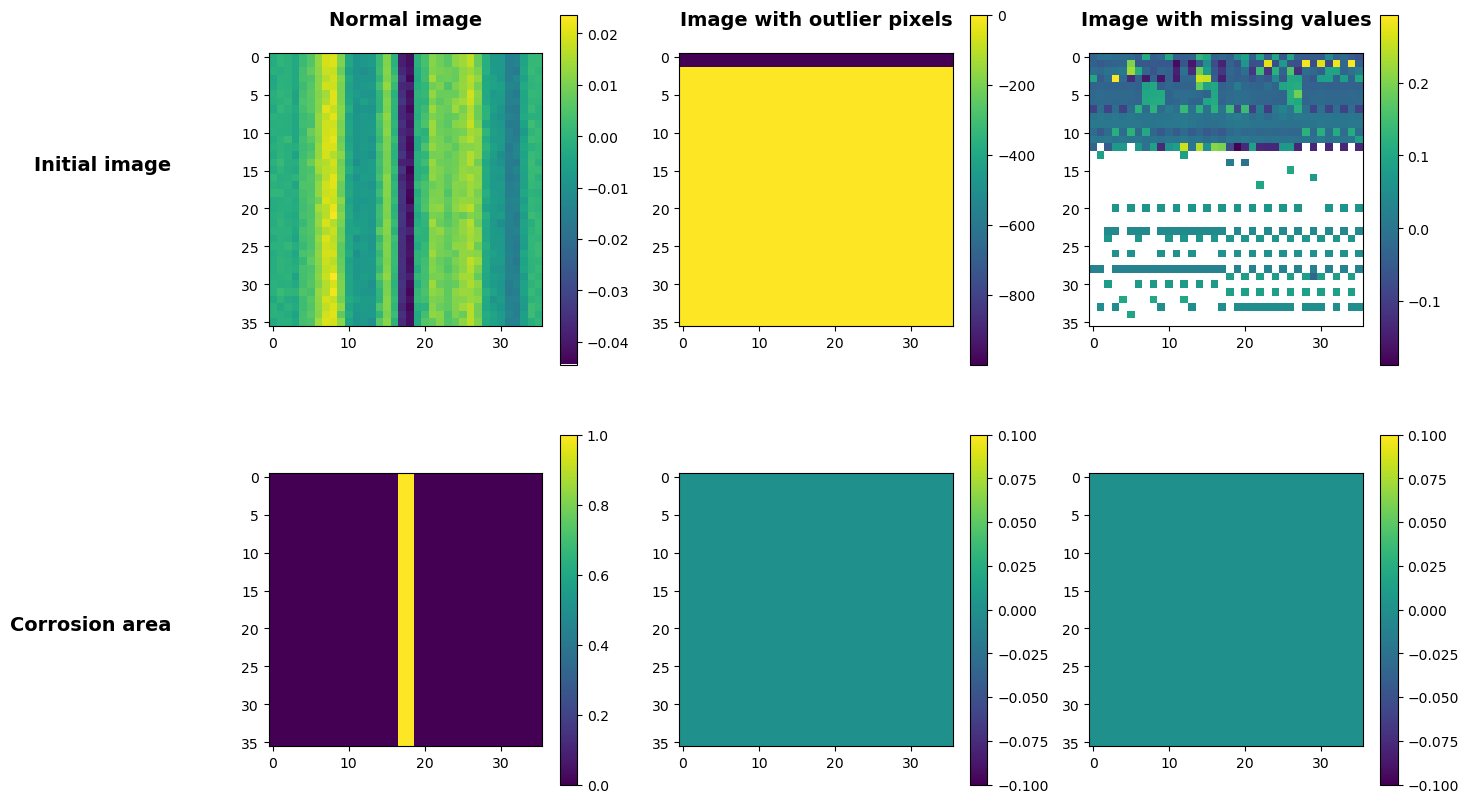

In [3]:
# Groundtruth
y_train = pd.read_csv("data/y_train.csv", index_col=0)

# Pick up some examples
outlier_example = "well_10_patch_0"
nan_example = "well_15_patch_202"
normal_example = "well_1_patch_0"

# Figure initialization
titles = ["Normal image", "Image with outlier pixels", "Image with missing values"]
fig, ax = plt.subplots(2,3, figsize=(15,10))
fig.text(0.06, 0.73 , 'Initial image', va='center', ha='right', fontsize=14, fontweight='bold')
fig.text(0.06, 0.27 , 'Corrosion area', va='center', ha='right', fontsize=14, fontweight='bold')


for i, name in enumerate([normal_example, outlier_example, nan_example]):
    
    # Load image and groundtruth
    x = np.load("data/x_train/" + name + ".npy")
    y = y_train.loc[name].values.reshape((36,36))
    
    # Plot image and groundtruth below
    ax[0,i].set_title(titles[i], fontsize=14, fontweight='bold', pad=20)
    im1 = ax[0,i].imshow(x)
    im2 = ax[1,i].imshow(y)
    plt.colorbar(im1, ax = ax[0,i])
    plt.colorbar(im2, ax = ax[1,i])
    


## Data pre-processing

As recommended on the context document, the pre-processing step is divided in three steps:

- The images with missing values will be removed (there's only two of them)
- The images containing outlier pixels will be removed. Outlier pixels are aberrant values which I considered as values with a z-score greater than 3 (a pixel z_score is computed with respect to the overall collection of images, not only the one to which the pixel belongs).
- The remaining images will be scaled using a robust scaler.

In [4]:
# Pre-process X
# The following function handles all the pre-processing and returns names of inlier patches and themselves after scaling.
inlier_names, X = preprocess("data/x_train", 3) # 3 is the limit z_score for outlier detection

# Only keep y values for inlier patches
y = y_train.loc[inlier_names]

340 files have been removed, 9334 still remain.


Here some examples of clean data.

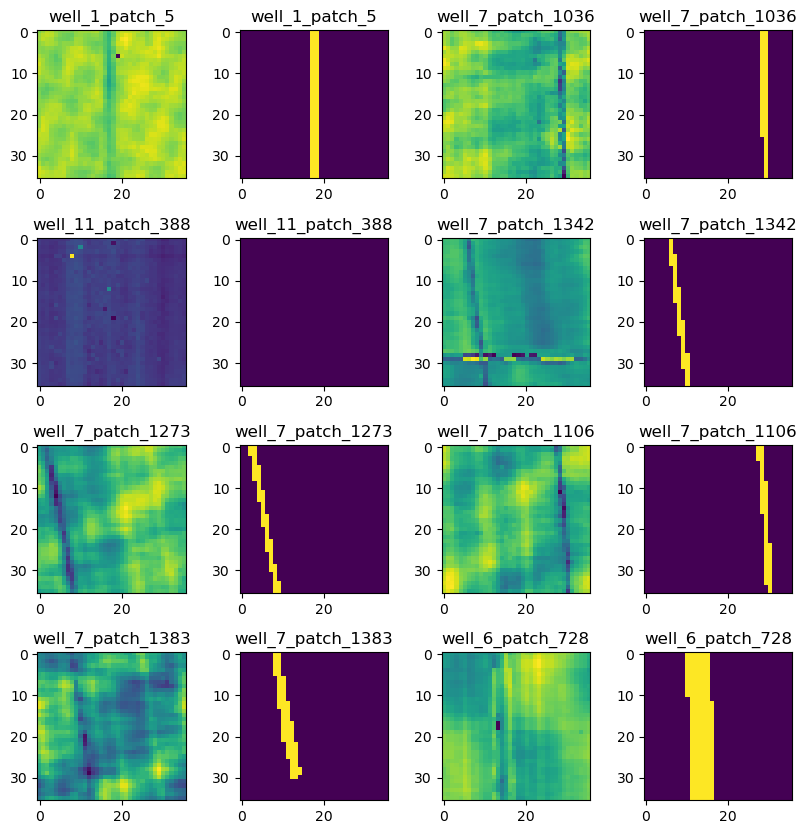

In [6]:
# Random examples
examples = random.sample(range(len(X)), 8)

plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=.4)
for i, ex in enumerate(examples):
    plt.subplot(4,4, 2*i+1)
    plt.imshow(X[ex])
    plt.title(inlier_names[ex])
    plt.subplot(4,4,2*i+2)
    plt.imshow(y.loc[inlier_names[ex]].values.reshape(36,36))
    plt.title(inlier_names[ex])


## Data aumentation

As suggested in the context document, we'll use some data augmentation techniques to generates a larger dataset $X$. Two methods will be used here:
- flipping each images horizontally and vertically (adds $2n$ images where $n$ is the number of original images).
- rolling each image horizontally with all possible shift values between 1 and 35 (adds $35n$ values).

This will multiply by $38$ our dataset. Of course, the same operation must be applied to the output data $y$. 

BEFORE augmentation
Input data shape: (9334, 36, 36, 1)
Output data shape:  (9334, 1296)

AFTER augmentation
Input data shape: (354692, 36, 36, 1)
Output data shape:  (354692, 1296)


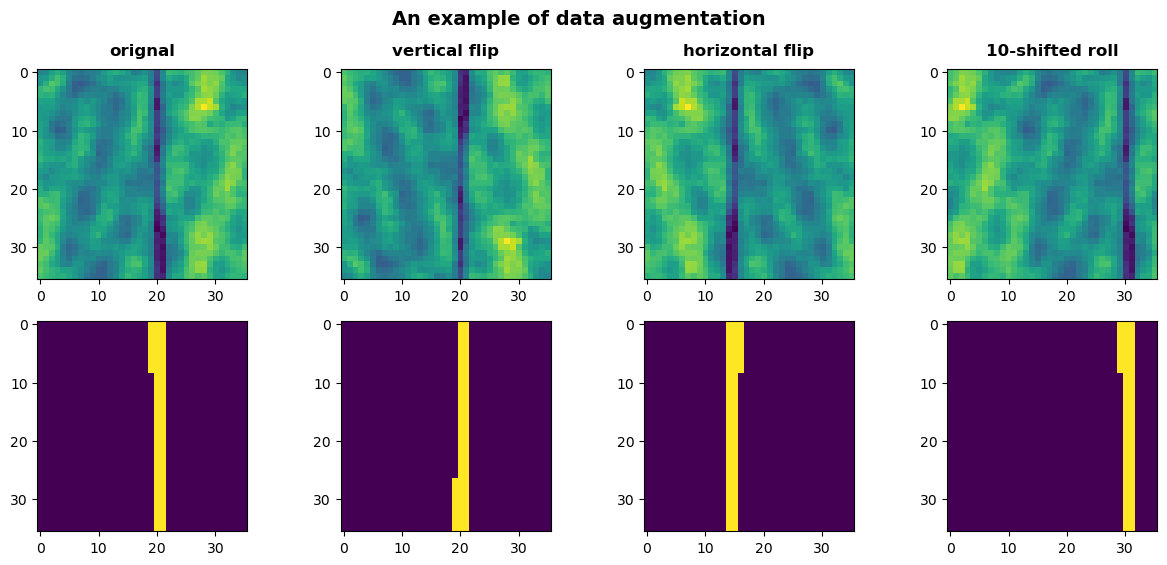

91400

In [7]:
# This fuction handle data augmentation as described above
X_augmented, y_augmented = data_augmentation(X,y)

# Display shapes
print("BEFORE augmentation")
print("Input data shape:", X.shape)
print("Output data shape: ", y.shape)
print("\nAFTER augmentation")
print("Input data shape:", X_augmented.shape)
print("Output data shape: ", y_augmented.shape)

# Visualization of data augmentation
name = "well_1_patch_16"
titles = ['orignal', 'vertical flip','horizontal flip', '10-shifted roll']
plt.figure(figsize=(15,6))
plt.suptitle("An example of data augmentation", fontsize=14, fontweight='bold')
for i, text in enumerate(['', "_vflip" , "_hflip", "_10roll"]):
    idx = y_augmented.index.get_loc(name+text)
    plt.subplot(2,4,i+1)
    plt.imshow(X_augmented[idx])
    plt.title(titles[i], fontweight='bold', pad=10)
    plt.subplot(2,4,i+5)
    plt.imshow(y_augmented.iloc[idx].values.reshape(36,36)) 
plt.show()


# del useless data to free RAM
del y_train, outlier_example, normal_example, nan_example, titles, fig, ax, i, name, inlier_names, X, y, x, examples, ex, idx, text
gc.collect()


## Model

In this part, we'll build and train the model. We're going to follow the brenchmark guidelines. First let's split our data between train and validation data.

TODO
- rajouter les commentaires de cette section
- challenge data.ens -> chall 144, participer et soumettre une solution. (SID emmanuele claeys)
- écrire le README

In [ ]:
# Train validation split
X_train, X_val, y_train, y_val = train_test_split(X_augmented, y_augmented, test_size=0.1, random_state=5)

# Free memory
del X_augmented, y_augmented
gc.collect()

0

Now, we'll define a model. As suggested in the benchmark guidelines, a CNN with 5 convolutional layers will be used. I also choose to add two dense layers. The following hyperparameters will be used:
- relu activation for hidden layers;
- sigmoid activation for the output layer;
- binary crossentropy as loss;
- adam with learning rate 0.001 as optimizer;
- 10 epohs (it takes almost 3 hours for training);
- batches of size 128.

In [9]:
# Model definition
inputs = Input(shape = (36,36,1))
x = Conv2D(8, (3,3), activation='relu')(inputs)
x = Conv2D(16, (3,3), activation='relu')(x)
x = Conv2D(32, (3,3), activation='relu')(x)
x = Conv2D(64, (3,3), activation='relu')(x)
x = Conv2D(128, (3,3), activation='relu')(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
outputs = Dense(36*36, activation='sigmoid')(x)

# Model creation
model = Model(inputs, outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 36, 36, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 34, 34, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │     8,652,900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1296)           │       130,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,882,036 (33.88 MB)

 Trainable params: 8,882,036 (33.88 MB)

 Non-trainable params: 0 (0.00 B)

Now the model is ready to be trained.

Epoch 1/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 1210s 480ms/step - loss: 0.1192 - val_loss: 0.0628
Epoch 2/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 1071s 429ms/step - loss: 0.0584 - val_loss: 0.0505
Epoch 3/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 975s 391ms/step - loss: 0.0437 - val_loss: 0.0435
Epoch 4/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 964s 387ms/step - loss: 0.0333 - val_loss: 0.0398
Epoch 5/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 955s 383ms/step - loss: 0.0265 - val_loss: 0.0378
Epoch 6/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 956s 383ms/step - loss: 0.0221 - val_loss: 0.0369
Epoch 7/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 953s 382ms/step - loss: 0.0191 - val_loss: 0.0391
Epoch 8/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 963s 386ms/step - loss: 0.0171 - val_loss: 0.0387
Epoch 9/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 954s 383ms/step - loss: 0.0154 - val_loss: 0.0377
Epoch 10/10
2494/2494 ━━━━━━━━━━━━━━━━━━━━ 953s 382ms/step - loss: 0.0139 - val_loss: 0.0389


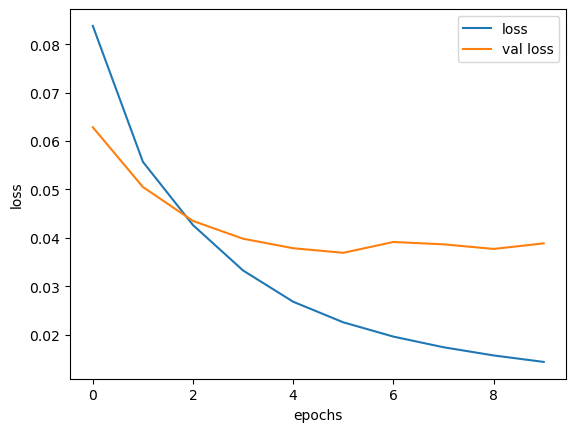

In [25]:
# Parameters
batch_size = 128
epochs = 10
lr = 0.001

# Compile and training
model.compile(optimizer=Adam(learning_rate=lr),
              loss=BinaryCrossentropy)
model.fit(X_train, y_train, 
          batch_size = batch_size,
          epochs=epochs,
          validation_data=(X_val, y_val))

# Plot loss evolution through epochs
hist = model.history.history
plt.plot(hist['loss'], label='loss')
plt.plot(hist['val_loss'], label = 'val loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

In [ ]:
# Save weights
"model.save_weights('CNN1.weights.h5')"

## Test model

In this part, we will test the model's performances on the validation data, using the IoU metric (Intersection over Union).

In [30]:
# Load weights
model.load_weights('CNN1.weights.h5')
pred = pd.DataFrame(model.predict(X_val, verbose=1), index = y_val.index)

1109/1109 ━━━━━━━━━━━━━━━━━━━━ 38s 34ms/step


As the model associates a value between 0 and 1 to each pixels, and we want only 0 and 1, we have to set up a threshold above witch a pixel is considered as 1 (corrosion). For that, let's try different threshold values and take the one with the best IoU.

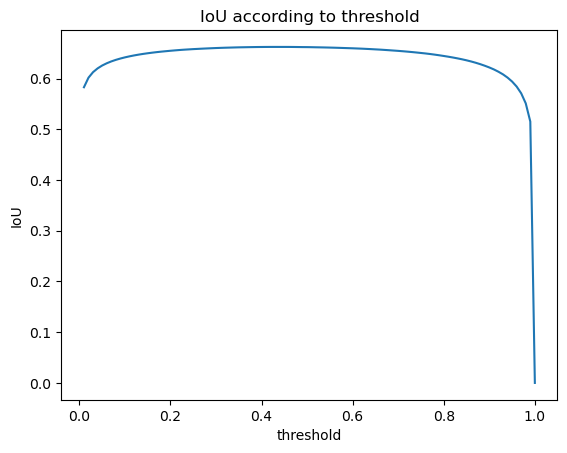

Best threshold:  0.43
Intersection over Union: 0.6625603576242518


In [44]:
# Initialize iou list and threshold list
iou = []
thresholds = 0.01*np.arange(1,101)

# Compute IoU for each threshold
for th in thresholds:  
    pred_th = 1*(pred > th)
    iou.append(IoU(pred_th, y_val))

# Plot results
plt.title("IoU according to threshold")
plt.plot(thresholds, iou)
plt.xlabel("threshold")
plt.ylabel("IoU")
plt.show()

# Keep the best threshold
best_th = thresholds[np.argmax(iou)]
best_iou = np.max(iou)
best_pred = 1*(pred > best_th)
print("Best threshold: ", best_th)
print("Intersection over Union:", best_iou)

Finally, we can compare the model output with reality for more visual results.

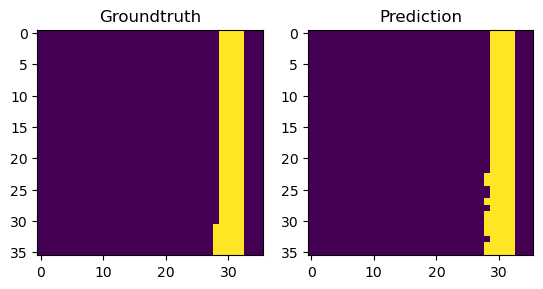

In [40]:
# Choose a random indice
i= np.random.randint(y_val.shape[0])

# Plot groundtruth
plt.subplot(1,2,1)
plt.title("Groundtruth")
plt.imshow(y_val.iloc[i].values.reshape(36,36))

# Plot prediction
plt.subplot(1,2,2)
plt.title("Prediction")
plt.imshow(best_pred.iloc[i].values.reshape(36,36))

plt.show()

## Use model on the x_test dataset

The project also provides a dataset named "x_test" with new data without the corresponding y_test. We have to find a prediction and submit it on the website.

In [75]:
inlier_names, X = preprocess("data/x_test", 200)
X.shape

0 files have been removed, 2538 still remain.


(2538, 36, 36, 1)

In [94]:
pred = pd.DataFrame((model.predict(X) > best_th) *1, index =inlier_names)

80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step


In [96]:
aberrant = np.unique(np.where(X<-100))
aberrant

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,   10,
         11,   12,   13,   14,   15,   16,   17,   18,   19,   20,   21,
         22,   23,   24,   25,   26,   27,   28,   29,   30,   31,   32,
         33,   34,   35,   41,   46,   51,   56,   58,   59,   64,   70,
         74,   79,   82,   85,   89,   90,   95,  100,  106,  111,  112,
        113,  116,  118,  121,  126,  131,  137,  142,  143,  147,  148,
        149,  152,  154,  157,  158,  160,  162,  163,  167,  174,  176,
        179,  185,  186,  190,  192,  195,  200,  201,  205,  212,  213,
        216,  221,  226,  230,  231,  237,  242,  247,  251,  252,  258,
        263,  267,  268,  269,  274,  278,  285,  290,  296,  300,  301,
        306,  311,  317,  322,  324,  327,  332,  335,  338,  342,  348,
        353,  358,  359,  363,  368,  369,  374,  380,  384,  389,  396,
        401,  407,  411,  412,  417,  422,  424,  427,  432,  437,  442,
        446,  448,  453,  460,  461,  462,  466,  4

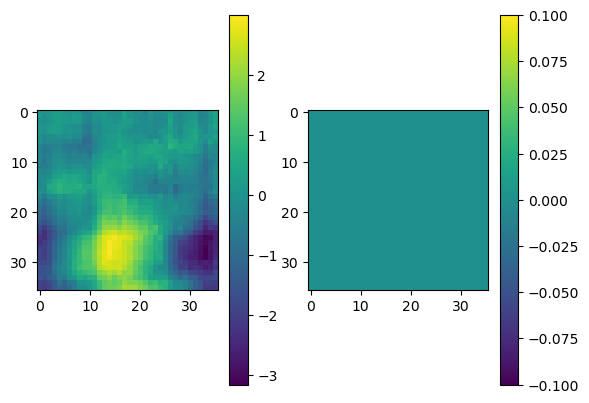

In [116]:
i= np.random.randint(X.shape[0])
plt.subplot(1,2,1)
plt.imshow(X[i])
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(pred.iloc[i].values.reshape(36,36))
plt.colorbar()

plt.subplots_adjust(hspace=.6)

In [74]:
sub = pd.read_csv("data/example_submission.csv", index_col=0)
sub.shape

(2538, 1296)

In [117]:
pred.to_csv("data/submission.csv")